In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
#import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'castellucci_mouse_usv_segmented'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [53]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=40000,
    mel_upper_edge_hertz=100000,
    butter_lowcut = 40000,
    butter_highcut = 100000,
    ref_level_db = 25,
    min_level_db = -10,
    mask_spec = True,
    win_length_ms = 5,
    hop_length_ms = 1,
    n_fft=2046,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

In [54]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    0.1s finished


In [9]:
dataset.sample_json

OrderedDict([('datetime', '2016-08-28_00-00-00'),
             ('samplerate_hz', 250000),
             ('length_s', 181.8624),
             ('wav_loc',
              '/mnt/cube/Datasets/mouse_usv/VOC594/VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04.WAV'),
             ('age', '33'),
             ('FemaleMouse', 'VOC586'),
             ('call_type', 'SONG'),
             ('weight', '20.04'),
             ('indvs',
              OrderedDict([('VOC594',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [22.666,
                                                         23.804,
                                                         23.892,
                                                         24.178,
                                                         24.2,
                                                         24.214,
                                  

In [10]:
len(dataset.data_files)

107

#### Create dataset based upon JSON

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.6s


[Parallel(n_jobs=-1)]: Done  71 out of 107 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  82 out of 107 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  93 out of 107 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 104 out of 107 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:    1.7s finished


21834

In [13]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04


### get audio for dataset

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   12.6s


[Parallel(n_jobs=-1)]: Done  61 out of  98 | elapsed:   13.7s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  71 out of  98 | elapsed:   17.2s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  81 out of  98 | elapsed:   18.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  91 out of  98 | elapsed:   19.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   21.0s finished


21834

In [15]:
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])

In [16]:
syllable_df = syllable_df[np.array(df_mask)]

In [17]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[3.85033670535963e-05, 0.00047644555496728587,...",250000
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[-0.0002335332372527899, 0.0007610424734092631...",250000
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.00036025126514952724, 0.0001731664493042362...",250000


In [18]:
sylls = syllable_df.audio.values

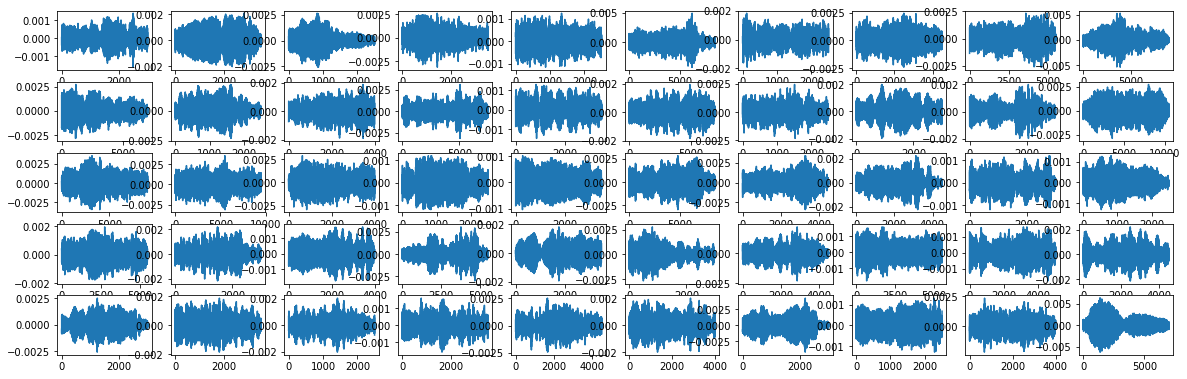

In [19]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [20]:
syllable_df['audio'] = [i/np.max(i) for i in syllable_df.audio.values]

### Create spectrograms

In [110]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [111]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [112]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0968s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1194s.) Setting batch_

[Parallel(n_jobs=-1)]: Done 21834 out of 21834 | elapsed:   15.5s finished


### Rescale spectrogram
- using log rescaling

In [113]:
log_scaling_factor = 4

In [114]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0077s.) Setting batch_size=52.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1742s.) Setting batch_size=118.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4668 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 6910 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 9152 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 11630 tasks      | elapsed:    1.6s
[Pa

[Parallel(n_jobs=-1)]: Done 21834 out of 21834 | elapsed:    2.4s finished


(25.0, 10) (320, 800) 25.0 32 800


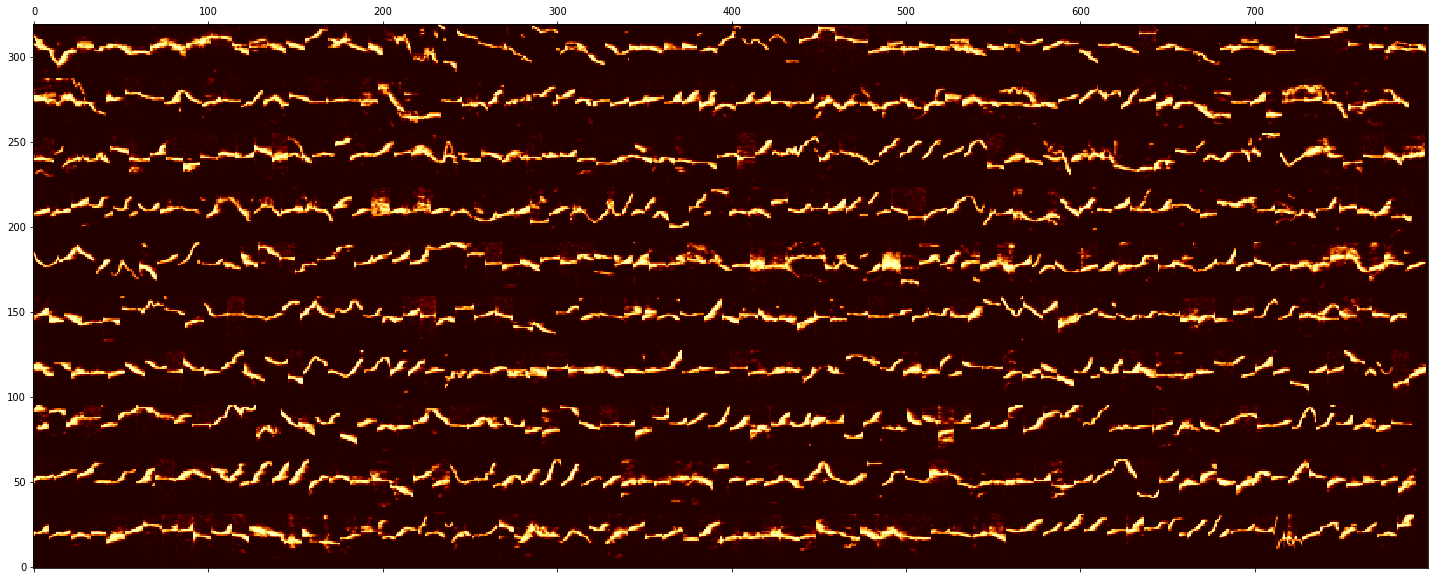

In [115]:
draw_spec_set(syllables_spec[5000:], zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [116]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [117]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.027472521623816974, 0.33994847238139614, -0...",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[-0.11161248771115849, 0.36372485865519466, 0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.13599627793788374, 0.06537101975011975, -0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [118]:
import seaborn as sns

In [1]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"] - syllable_df[syllable_df.indv==indv]["start_time"]), label=indv)
plt.legend()

NameError: name 'np' is not defined

In [120]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0097s.) Setting batch_size=40.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1400s.) Setting batch_size=114.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 6134 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8300 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 10466 tasks      | elapsed:    1.4s
[Pa

[Parallel(n_jobs=-1)]: Done 21834 out of 21834 | elapsed:    2.4s finished


In [121]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [125]:
def remove_med(x):
    x[x<=np.median(x)] = 0
    return x

In [123]:
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]
syllables_spec = [remove_med(i) for i in tqdm(syllables_spec)]

TypeError: 'int' object does not support item assignment

(25.0, 10) (320, 800) 25.0 32 800


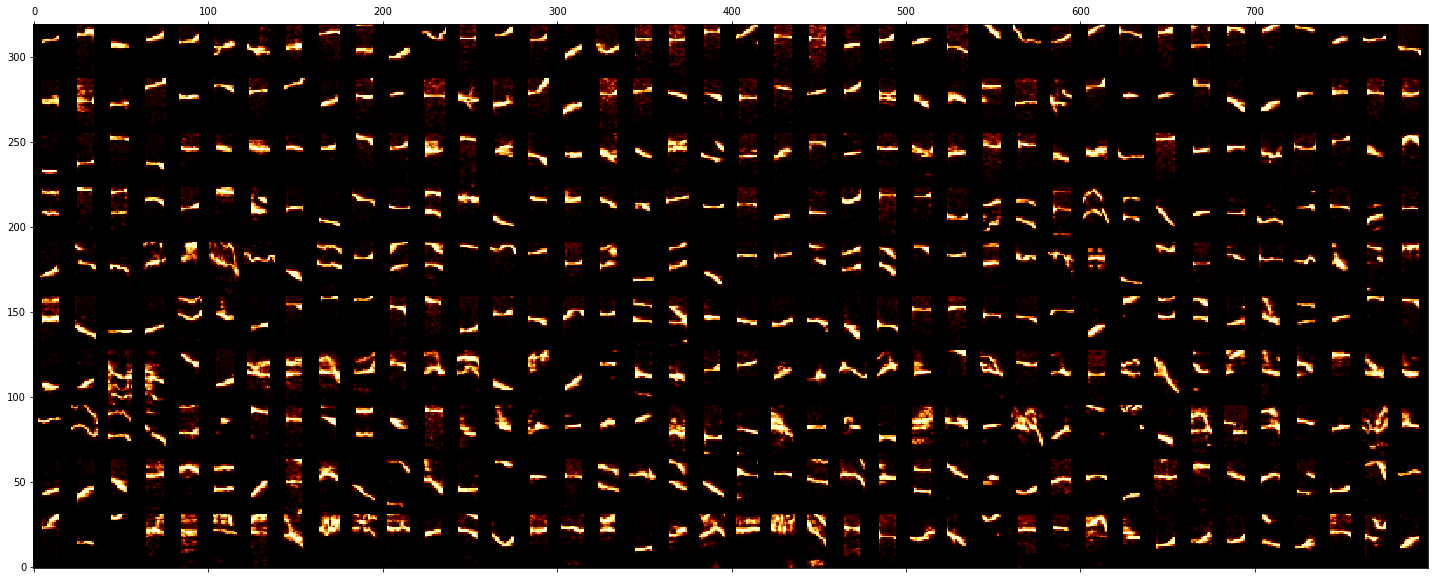

In [127]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [128]:
np.shape(syllables_spec)

(21834, 32, 20)

In [129]:
syllable_df['spectrogram'] = syllables_spec

In [130]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,22.666,22.678,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.027472521623816974, 0.33994847238139614, -0...",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,23.804,23.818,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[-0.11161248771115849, 0.36372485865519466, 0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,23.892,23.902,VOC594,0,VOC594_VOC586_SONG_CMPA_8_28_2016_33_20.04,"[0.13599627793788374, 0.06537101975011975, -0....",250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### view syllables per indv

In [131]:
syllable_df.indv.unique()

array(['VOC594', 'VOC592', 'VOC591', 'VOC597'], dtype=object)

VOC591 7856
(50.0, 32) (512, 800) 25.0 32 800


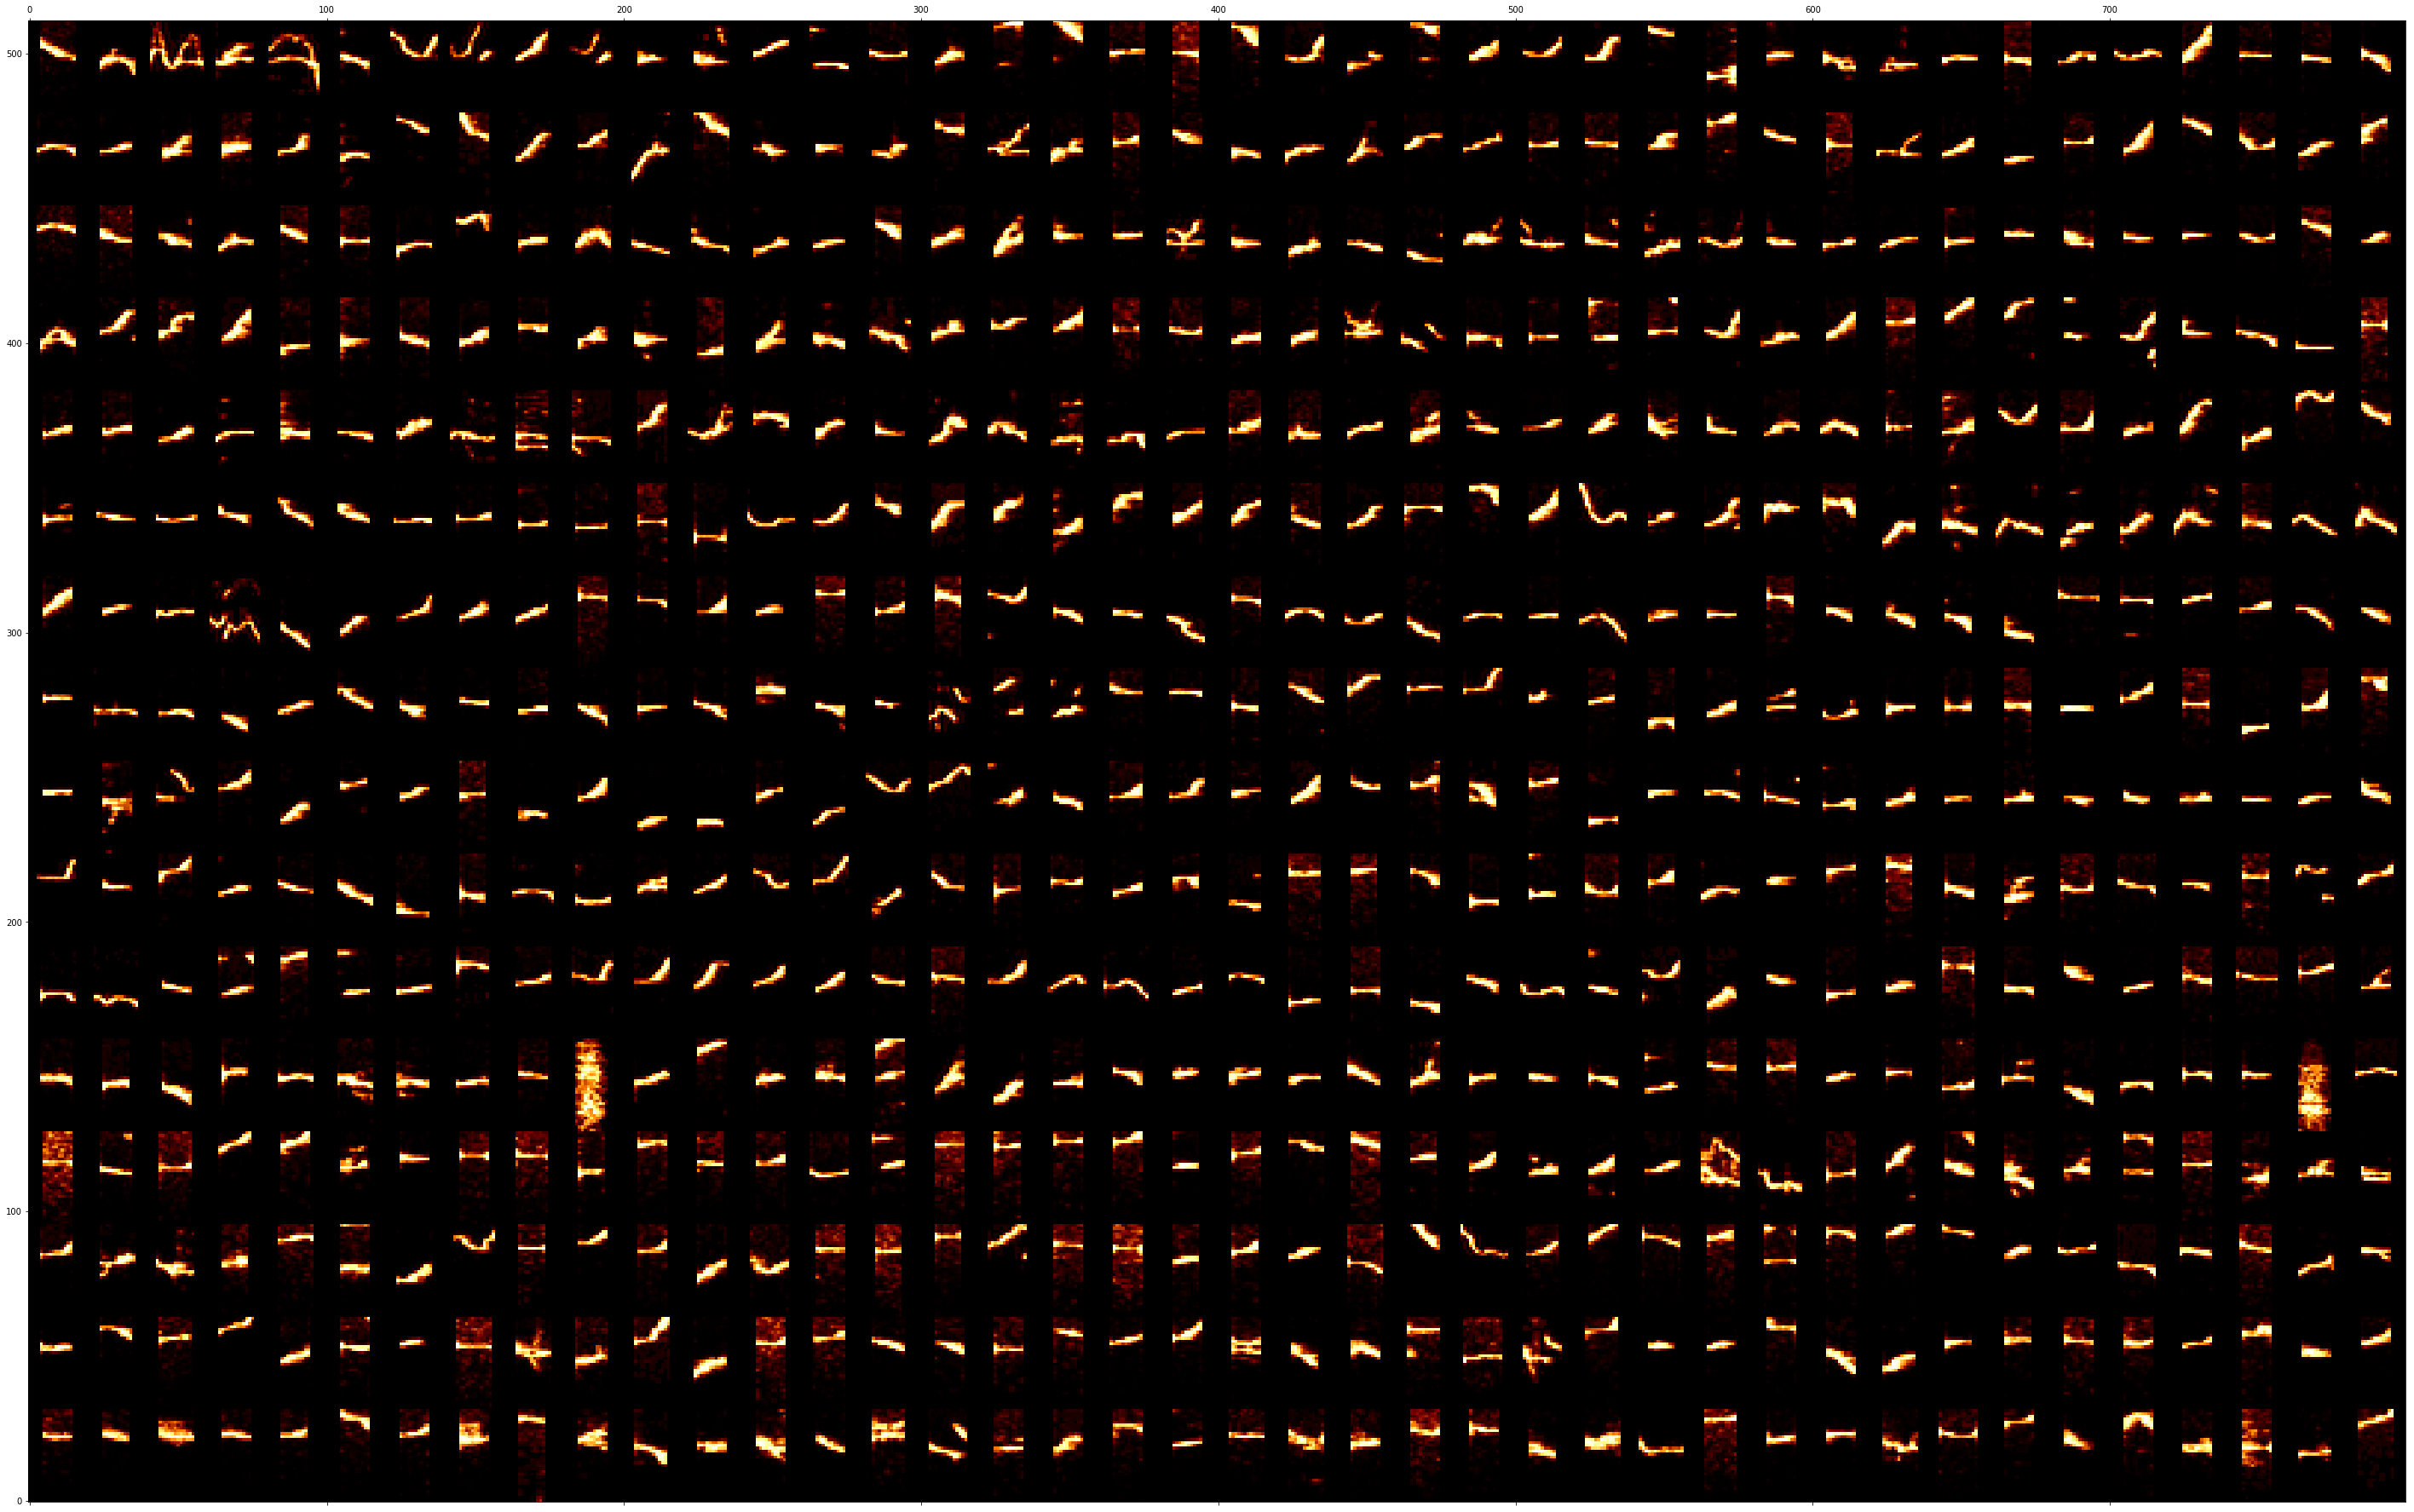

VOC592 4101
(50.0, 32) (512, 800) 25.0 32 800


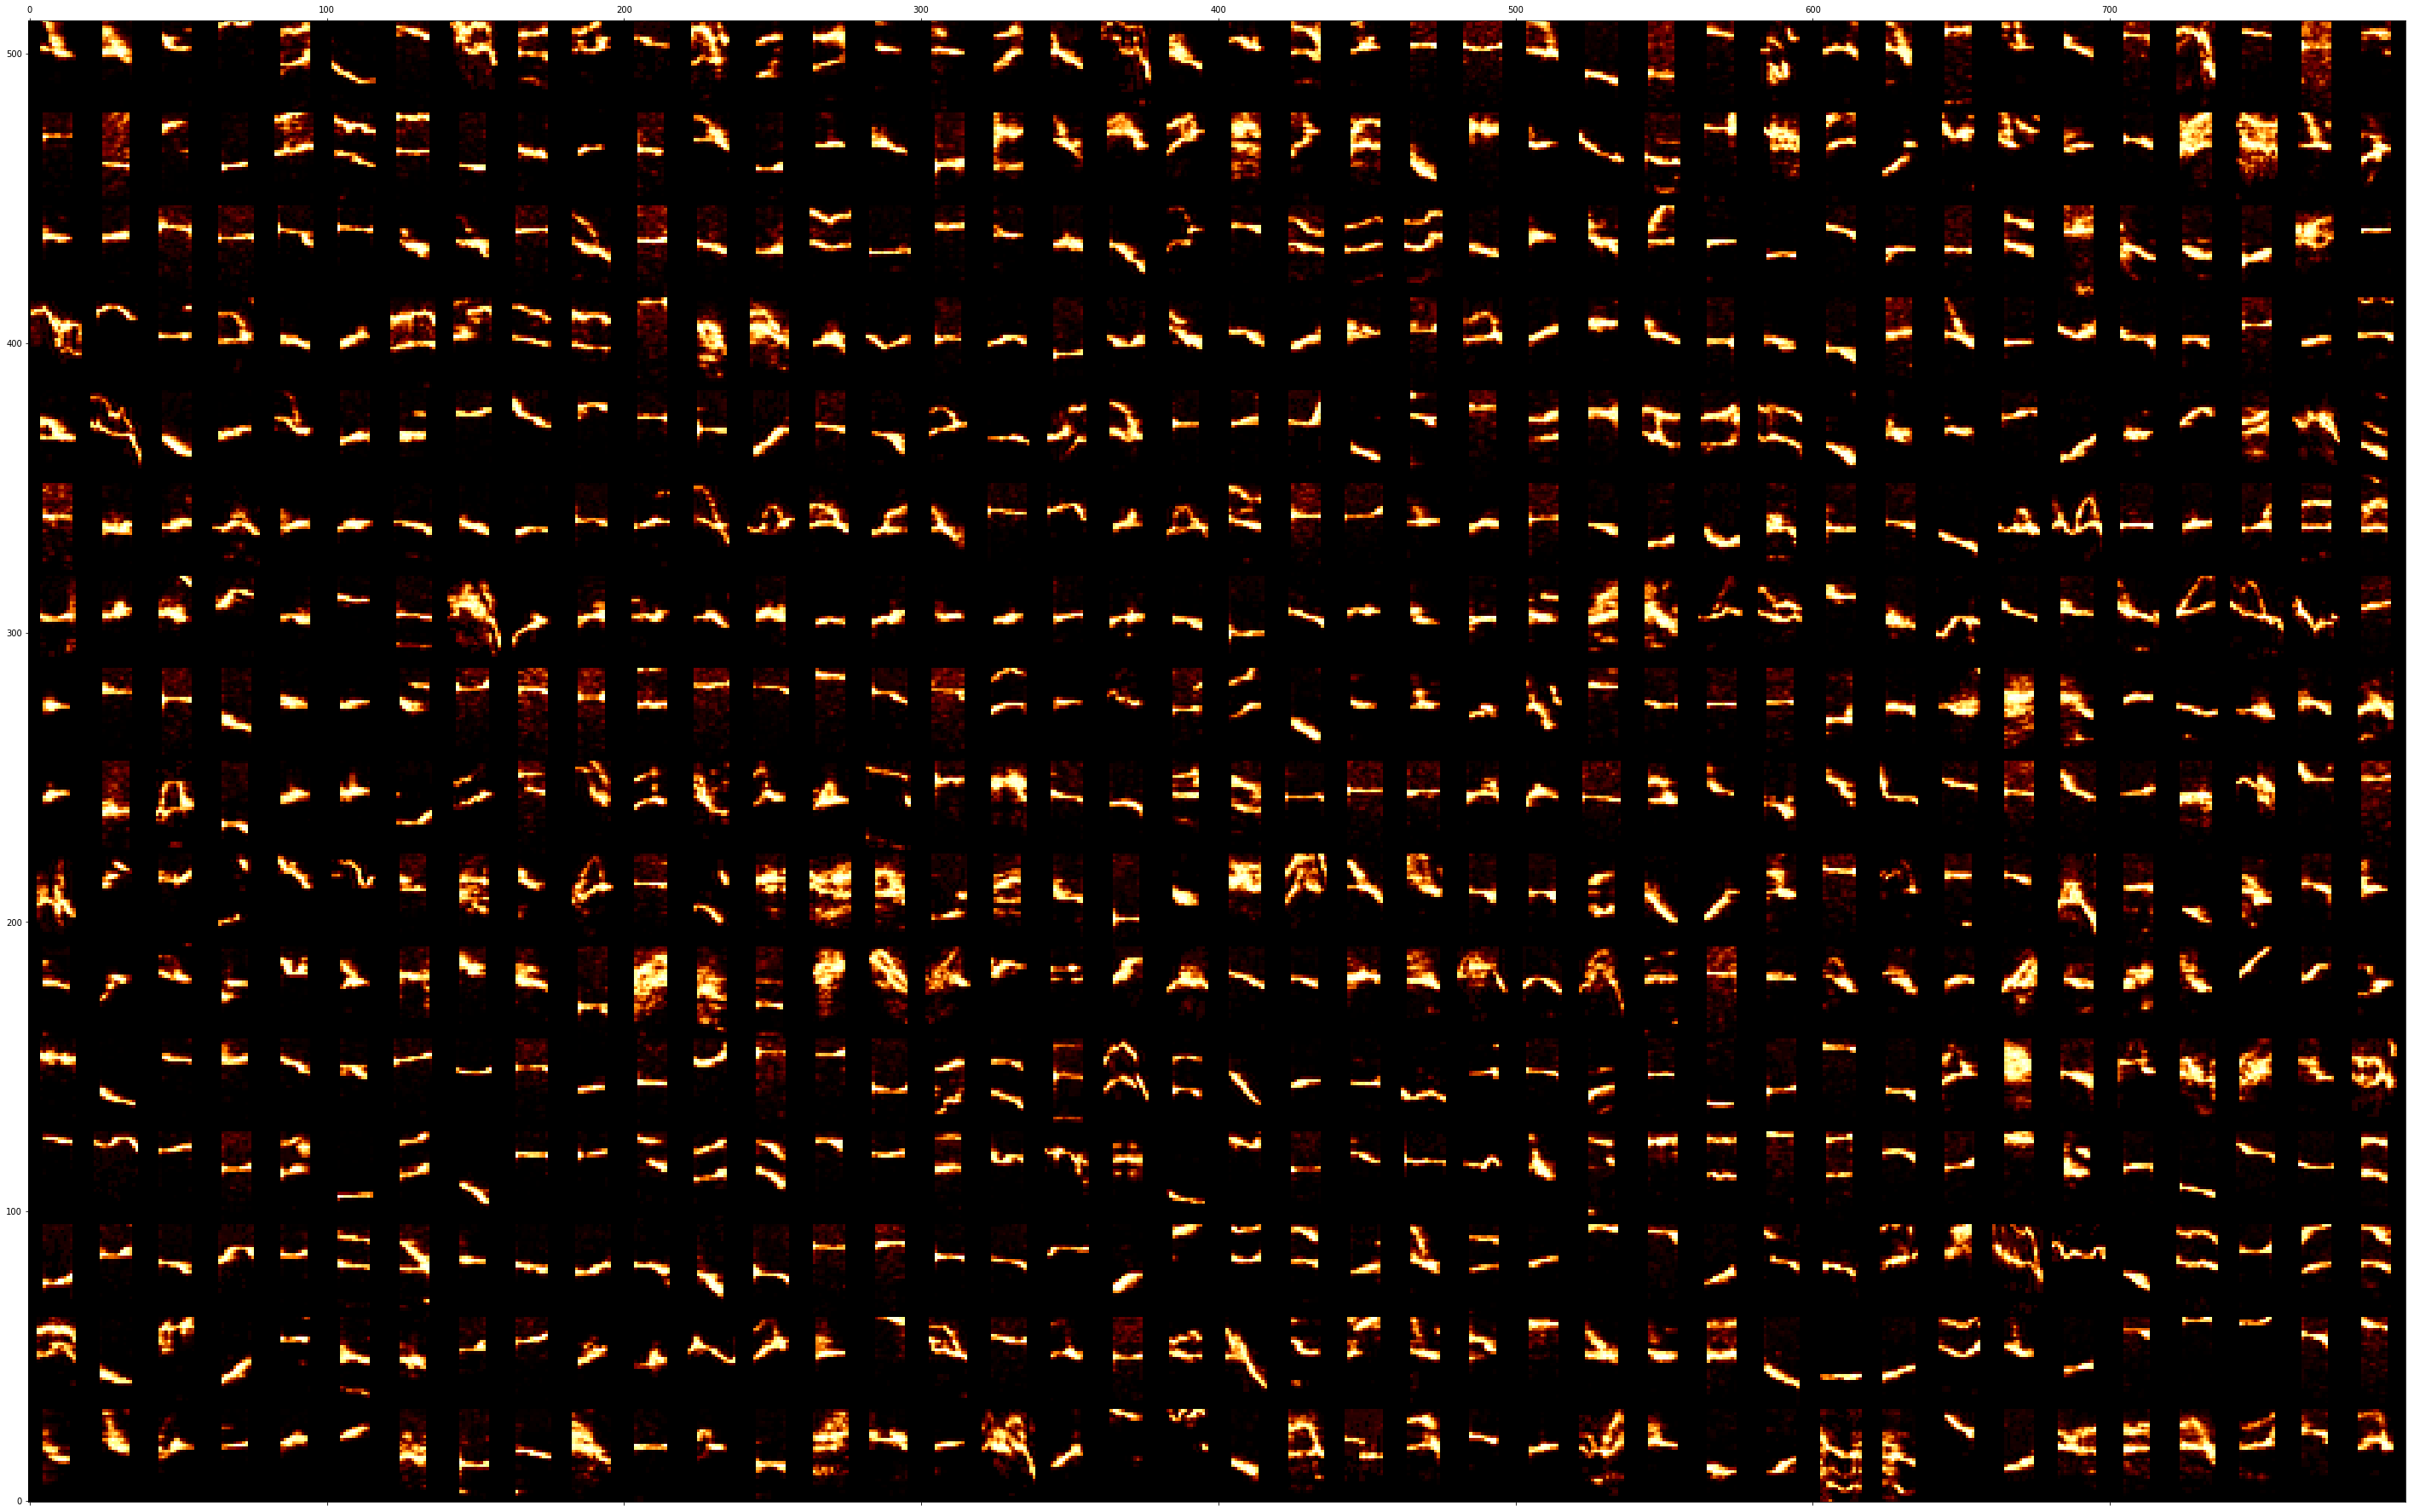

VOC594 8302
(50.0, 32) (512, 800) 25.0 32 800


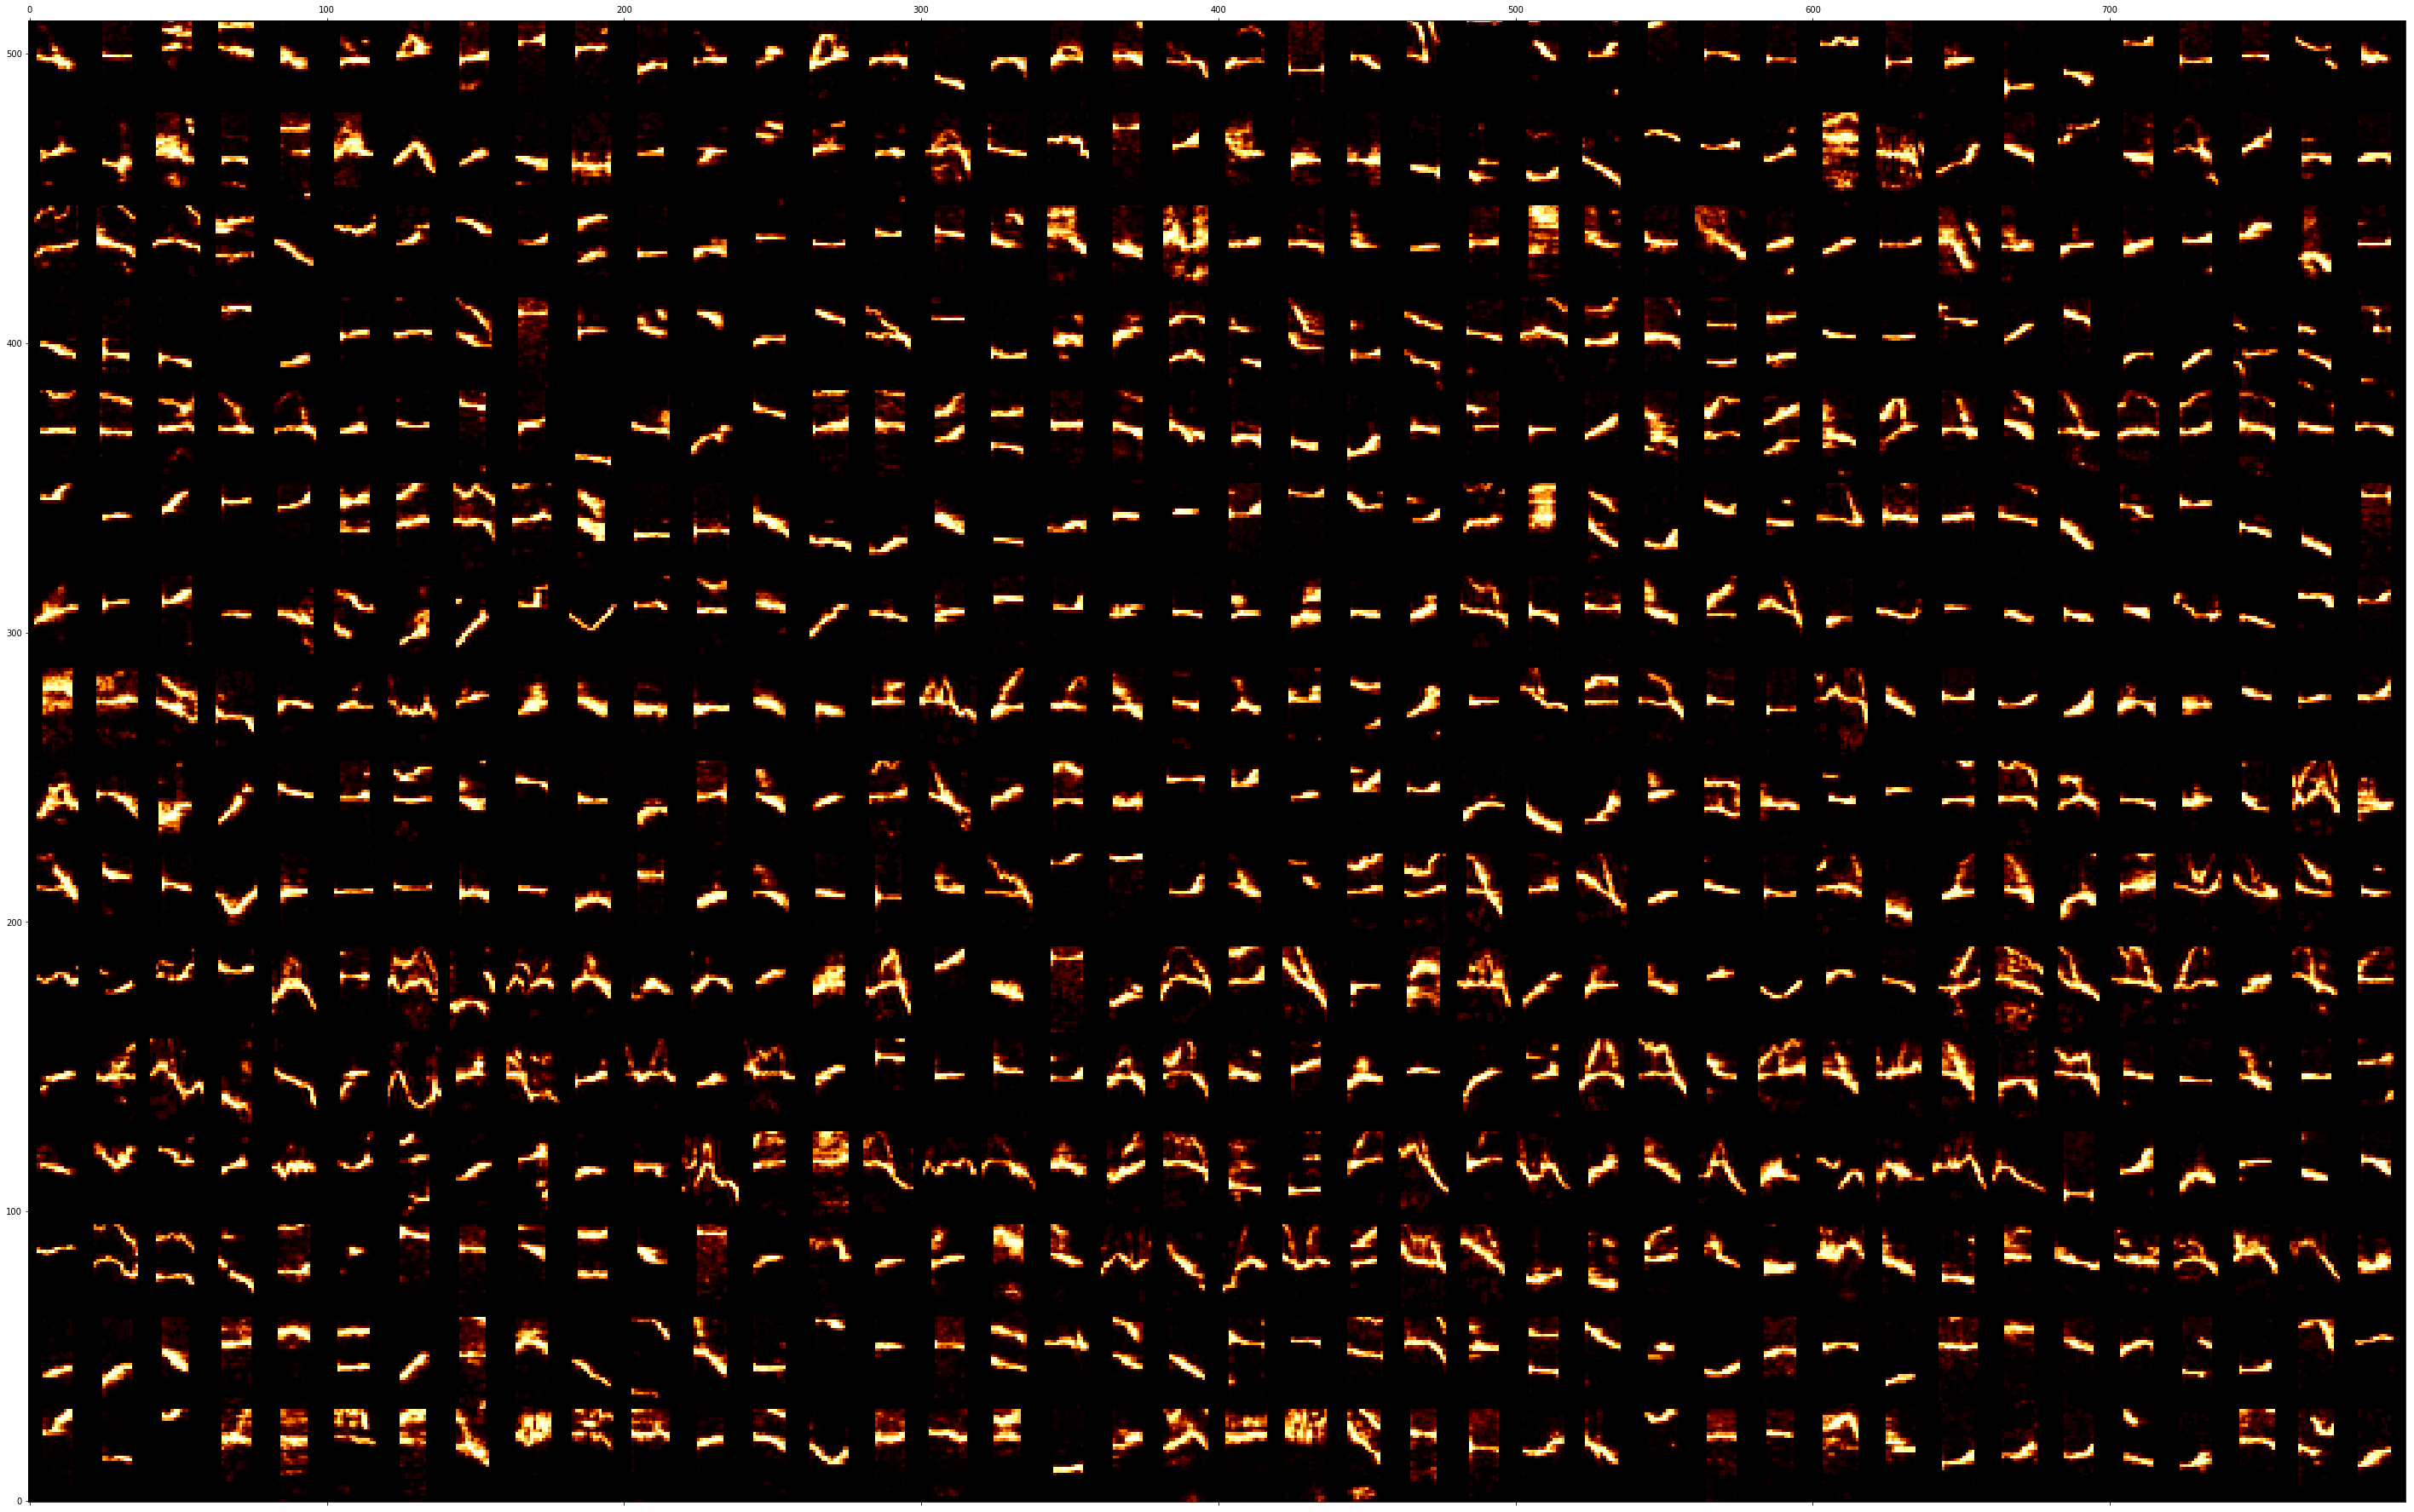

VOC597 1575
(50.0, 32) (512, 800) 25.0 32 800


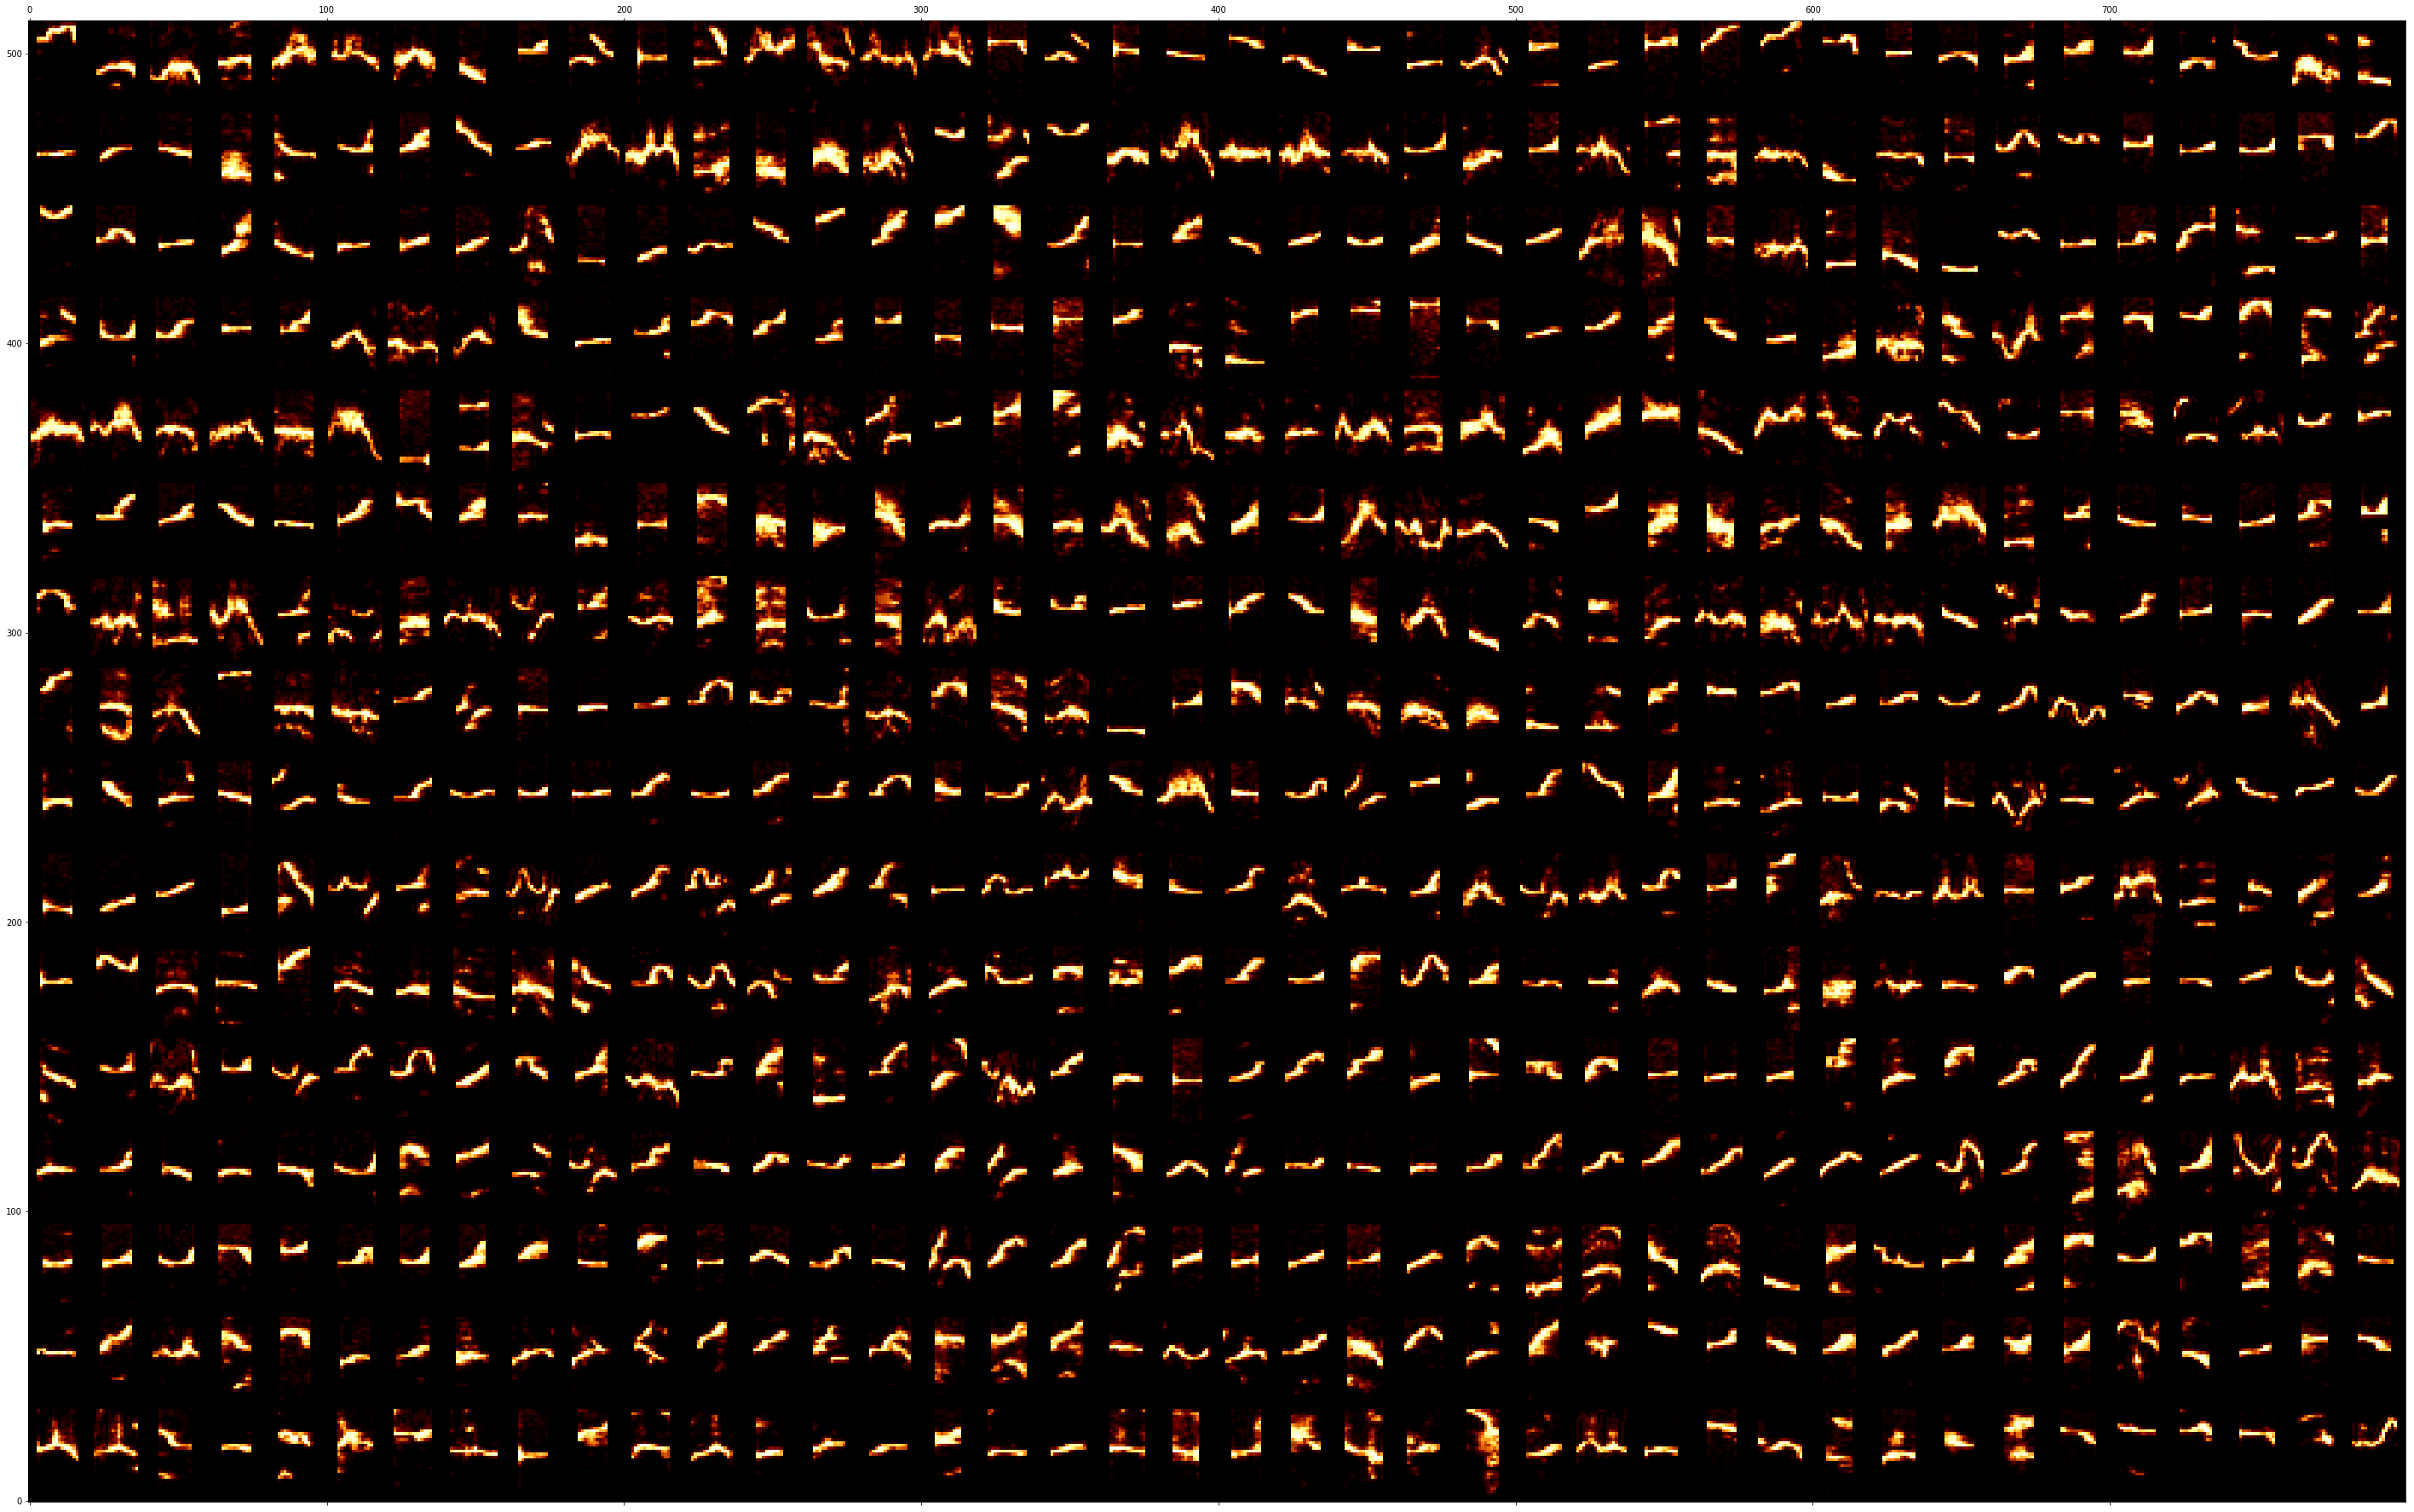

In [132]:
for indv in np.sort(syllable_df.indv.unique()):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [133]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'mouse.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)